# Introduction

The traditional, matrix-factorization-based approach presented in the notebook Recommender_system_1.ipynb is one of the most frequently used methods of creating recommender systems, but not the only one. In this notebook, we focus on applying two deep learning models for this task: a neural collaborative filtering model and NeuMF, both implemented in Keras. As artificial neural networks are able to model nonlinear dependencies between input features (a trait that the traditional matrix factorization do not possess), we expect them to better learn the underlying structure of customer-product interaction.

Due to the specific of the dataset we divided our problem into two variants:
<ul>
<li> Customer-product approach - we use a model to predict a rating for each customer - product pair. This way we can provide a precise, dedicated recommendation for each customer based on their previous orders and satisfaction level. However, the disadvantage of this approach comes from the fact that the dictionaries of customers and items are fixed - the model has to be retrained every time a new entry appears in one of them. It increases the computational costs and makes the model unusable for cold start entries (e.g. customers that didn't rate anything yet). On the other hand, these issues can be partially solved - the cold start problem by providing initial recommendations from other sources (e.g. popularity based or from the state-category approach below), and the computational cost problem by retraining the model periodically (e.g. each month).</li>
    
<li>
State-category approach - in this approach we train a DL model to predict an average review score for pairs customer state - product category. This method results in models that generalize better - they are to be retrained only when a set of categories or states change (which shouldn't be a frequent event), their embedding layers are smaller (require less disk space to be stored) and can be used for recommending product categories for cold start customers given that their location is known.
</li>
</ul>

We further divide the first variant into two subapproaches:
<ul>
<li> Explicit feedback/Multiclass - the target value is a number from a range from 1 to 5, representing a review score given by a customer to a particular product. It can be used later to build popularity rankings.
</li>
<li>
Implicit feedback/Binary - the target value is either 0 (non-perfect review score, 1-4) or 1 (perfect review score). This approach was introduced mainly to deal with the imbalancement of the dataset, but its value lays in an implicit feedback recommendation. A positive predicted rating (1) suggests that based on the previous experiences the customer will be satisfied by and/or interested in the product. Given a limited advertising space, the ecommerce sellers can use it more efficiently by showing the customers only the items that they are most likely to interact with.</li>   

</ul>

In [302]:
!pip install -q -U keras-tuner
!pip install surprise
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder,LabelEncoder, StandardScaler
from keras.models import Model
from keras.layers import Input, Reshape, Dot, Add, Activation, Lambda, Concatenate, Dense, Dropout, Multiply, BatchNormalization
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import KFold, StratifiedKFold
from keras.callbacks import ModelCheckpoint
from keras import backend
import pickle
import kerastuner as kt
import os
from keras import backend as K
from surprise import Reader, Dataset

In [303]:
def plot_confusion_matrix(test_labels, predicted_labels, save_path=None, encoder=None):
    if encoder:
      test_labels = encoder.inverse_transform(test_labels)
      predicted_labels = encoder.inverse_transform(predicted_labels)

    conf_matrix = confusion_matrix(test_labels, predicted_labels)
    conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=[10, 10], dpi=100)
    im = ax.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    classes = unique_labels(test_labels, predicted_labels)
    if conf_matrix.shape[1] > 2:
      classes = np.arange(1, 6)
    else:
      classes = np.arange(conf_matrix.shape[0])
    ax.set(xticks=np.arange(conf_matrix.shape[1]),
           yticks=np.arange(conf_matrix.shape[0]),
           xticklabels=classes, yticklabels=classes,
           ylabel='True label',
           xlabel='Predicted label')
    fmt = '.3f'
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(j, i, format(conf_matrix[i, j], fmt),
                    ha="center", va="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

In [304]:
def plot_history(history, metric='accuracy', loss='mse'):
    if metric:
        plt.plot(history.history[metric])
        plt.plot(history.history[f'val_{metric}'])
        plt.title(f'Model {metric}')
        plt.ylabel(metric)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'])
        plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel(loss)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'])
    plt.show()

# Model definition

The code below defines the functions used later to build each model. The code was prepared based on the 

 First we define the <i>EmbeddingLayer</i>, which consists of a standard Keras Embedding layer, followed by reshaping, as it is used in both models.

## Neural Collaborative Filtering - NCF

This model introduces nonlinearity to the collaborative filtering approach by concatenating user and item embeddings and stacking dense neural layers on top of them. It is a general framework that can be adjusted to model different kind of functions, including a standard matrix factorization, multiclass and binary classification, and regression.

<i>CFRegressor</i> is our implementation of the NCF model adjusted for regression problems. We decided to separate it from the basic <i>CollaborativeFiltering</i> to make both functions easier to read and safer to manipulate.

## Neural Matrix Factorization - NeuMF

This model combines the benefits coming from the matrix factorization and MLP-based methods by consisting of two subnetworks ("legs"). Both start with learning the embedding vectors for input features (e.g. user-item) independently to ensure higher flexibility. Next, one subnetwork (GMF - Generalized Matrix Factorization) calculates an element-wise product of its embedding vectors, while the other (MLP - Multilayer Perceptron) concatenates them and passes through a set of densely connected layers. At the end, signals from both subnetworks are concatenated and the output value is determined.


References:
<ul>
<li>Xiangnan He, Lizi Liao, Hanwang Zhang, Liqiang Nie, Xia Hu, Tat-Seng Chua: “Neural Collaborative Filtering”, 2017; <a href='http://arxiv.org/abs/1708.05031'>arXiv:1708.05031</a></li>
<li>https://medium.com/@jdwittenauer/deep-learning-with-keras-recommender-systems-e7b99cb29929</li>
</ul>

In [305]:
class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items+1, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x

In [306]:
def CollaborativeFiltering(value_counts: list, n_factors, output_nodes = 1, dense_nodes=1):
    inputs = []
    emb_layers = []
    for ii, count in enumerate(value_counts):
        inputs.append(Input(shape=(1,)))
        emb_layers.append(EmbeddingLayer(count+1, n_factors)(inputs[ii]))
    
    x = Concatenate()(emb_layers)

    
    x = Dense(dense_nodes, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    
    x = Dense(output_nodes, kernel_initializer='he_normal')(x)
    if output_nodes == 1:
        x = Activation('sigmoid')(x)
    else:
        x = Activation('softmax')(x)
    model = Model(inputs=inputs, outputs=x)
    opt = Adam(lr=0.001)
    if output_nodes == 1:
        model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])
    else:
        model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [307]:
def CFRegressor(value_counts: list, n_factors, output_nodes = 1, dense_nodes=1):
    inputs = []
    emb_layers = []
    for ii, count in enumerate(value_counts):
        inputs.append(Input(shape=(1,)))
        emb_layers.append(EmbeddingLayer(count+1, n_factors)(inputs[ii]))
    
    x = Concatenate()(emb_layers)

    
    x = Dense(dense_nodes, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    model = Model(inputs=inputs, outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mse', optimizer=opt)
    return model

In [308]:
def NeuMF(n_customers, n_products, n_factors, nums_hiddens: list = [10]):
    
    customer_input = Input(shape=(1,))
    product_input = Input(shape=(1,))

    P = EmbeddingLayer(n_customers, n_factors)(customer_input)
    Q = EmbeddingLayer(n_products, n_factors)(product_input)
    U = EmbeddingLayer(n_customers, n_factors)(customer_input)
    V = EmbeddingLayer(n_products, n_factors)(product_input)
    
    gmf = Multiply()([P, Q])
    
    
    mlp = Concatenate()([U, V])
    
    for num_hidden in nums_hiddens:
        mlp = Dense(num_hidden)(mlp)
        mlp = Activation('relu')(mlp)
    
    neumf = Concatenate()([gmf, mlp])
    neumf = Dense(1)(neumf)
    neumf = Activation('sigmoid')(neumf)
    
    
    
    model = Model(inputs=[customer_input, product_input], outputs=neumf)
    opt = Adam(lr=0.001)
    
    model.compile(loss='mse', optimizer=opt, metrics=['accuracy'])
    return model

# Customer-product approach

## Feature set preparationpath = '.'

The customers with a number of ratings lower than 2 are treated as cold start users and dropped from the dataset. The split between train and test set is done based on the delivery date - for each customer, the most recent order is treated as a test entry, while the rest are used for training. This helpes to prevent data leakage, which could appear if we tried to predict an older rating based on the knowledge collected about the customer's preferences later. Due to the relatively small number of ratings coming from each customer we decided to use the test set for validation as well.

In [191]:
path = '.'
df = pd.read_csv(path + '/recommender.csv', index_col=0)

In [193]:
df.head()

,review_score,customer_state,seller_state,product_id,product_category_name_english,customer_unique_id,order_delivered_customer_date,price,delivered_date,days_diff,order_weekday,order_month,price_category,day_category
0,4,SP,SP,17106,housewares,45758,2017-10-10 21:25:13,29.99,2017-10-10,8.0,Monday,Oct,Low,morning
1,4,SP,SP,17106,housewares,21530,2017-08-18 14:44:43,29.99,2017-08-18,3.0,Tuesday,Aug,Low,afternoon
2,5,SP,SP,17106,housewares,87936,2017-08-07 18:30:01,29.99,2017-08-07,5.0,Wednesday,Aug,Low,afternoon
3,3,SC,SP,17106,housewares,85228,2017-11-07 18:04:59,29.99,2017-11-07,15.0,Monday,Oct,Low,evening
4,1,SP,SP,23951,housewares,44958,2017-08-28 20:12:20,46.80,2017-08-28,4.0,Thursday,Aug,Low,morning


In [194]:
df = df.loc[:,'product_category_name_english,price,seller_state,customer_unique_id,product_id,review_score,order_delivered_customer_date'.split(',')].drop_duplicates()

In [195]:
def binarize_ratings(rating):
    if rating == 5:
        return 1
    else:
        return 0

In [196]:
df['rating'] = df['review_score'].apply(binarize_ratings)

In [197]:
df.rating.value_counts()

1    57846
0    43325
Name: rating, dtype: int64

In [198]:
def encode_columns(df, columns_encoded, columns_to_enc):
    encoders = dict()
    uniques = dict()
    for col_enc, col2enc in zip (columns_encoded, columns_to_enc):
        enc = LabelEncoder()
        df[col_enc] = enc.fit_transform(df[col2enc].values)
        n = df[col_enc].nunique() # to be corrected, nunique
        encoders[col_enc] = enc
        uniques[col_enc] = n
    return df, uniques, encoders

In [199]:
df_enc, value_counts, encoders = encode_columns(df, 'category,state,customer,product'.split(','), 'product_category_name_english,seller_state,customer_unique_id,product_id'.split(','))

In [200]:
value_counts

{'category': 71, 'state': 23, 'customer': 94088, 'product': 32328}

In [201]:
df_enc.rename(columns={'order_delivered_customer_date': 'timestamp'}, inplace=True)

In [202]:
df_enc = df_enc.loc[:,'timestamp,category,state,customer,product,rating,review_score'.split(',')]

In [203]:
df_enc.customer.value_counts()

51876    15
22987    13
74527     9
10145     9
73985     8
         ..
45056     1
88063     1
90110     1
83965     1
2047      1
Name: customer, Length: 94088, dtype: int64

In [204]:
df_no_cold = df_enc[df_enc.groupby('customer').customer.transform('count')>1].copy()

In [206]:
df_no_cold.customer.value_counts()

51876    15
22987    13
74527     9
10145     9
39253     8
         ..
92816     2
46029     2
31692     2
65063     2
7015      2
Name: customer, Length: 5697, dtype: int64

In [207]:
df_test = df_no_cold.sort_values('timestamp', ascending=False).groupby(['customer']).head(1)

In [208]:
df_train = df_no_cold[~df_no_cold.index.isin(df_test.index)]

In [210]:
X_train = [df_train.loc[:,'customer'].values, df_train.loc[:,'product'].values] 
X_test = [df_test.loc[:,'customer'].values, df_test.loc[:,'product'].values]


## Multiclass approach

### Label selection

In [313]:
y_train = df_train.review_score
y_test = df_test.review_score

In [314]:
# ANNs require the classes array to be zero-based, so by subtracting 1 from 
# each review score we obtain a range from 0 to 4
y_train = y_train - 1
y_test = y_test - 1

In [315]:
y_train.value_counts()

4    3504
0    1395
3    1103
2     686
1     395
Name: review_score, dtype: int64

In [316]:
y_test.value_counts()

4    2900
0    1091
3     858
2     542
1     306
Name: review_score, dtype: int64

The dataset is significantly imbalanced, as some classes are much more frequent than others. Due to that, we will consider three approaches - basic one (without any modifications), with oversampling and with class weighting. In all cases we treat the accuracy score as a helper metric of less significance, since it does not take the imbalancement into consideration. The main model evaluation is thus performed using a normalized confusion matrix and metrics from scikit-learn's classification report (precision, recall, f1-score).

The models' hyperparameters (mainly the number of embedding factors and the number of nodes in dense layers) were selected by trial-and-error, as the networks appeared to be highly prone to overfitting and other bizare effects. One of such effects, worthy of mentioning, was the accuracy keeping a constant value while the loss function keeped decreasing. This may be explained by the fact that classification metrics (such as accuracy) take into consideration labels (integer values), while loss functions (like mean squared error or categorical crossentropy) work on predictions (floating-point numbers). For example, given a true label 1, the accuracy score will be 100% both for prediction result of 0.51 and 0.99, while a loss function will be smaller for the latter case.

### CF - multiclass

In [317]:
n_factors = 5
model_cf_multiclass = ColaborativeFiltering([value_counts['customer'], value_counts['product']], n_factors, output_nodes=5, dense_nodes=10)

history = model_cf_multiclass.fit(x=X_train, y=y_train, batch_size=10**6, epochs=500,
                    verbose=0, validation_data=(X_test, y_test))

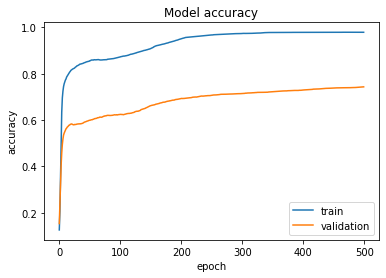

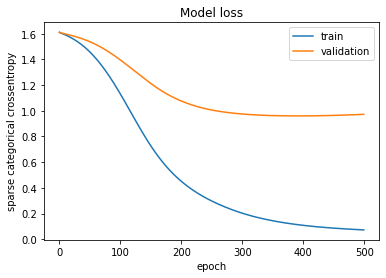

In [318]:
plot_history(history, 'accuracy', 'sparse categorical crossentropy')

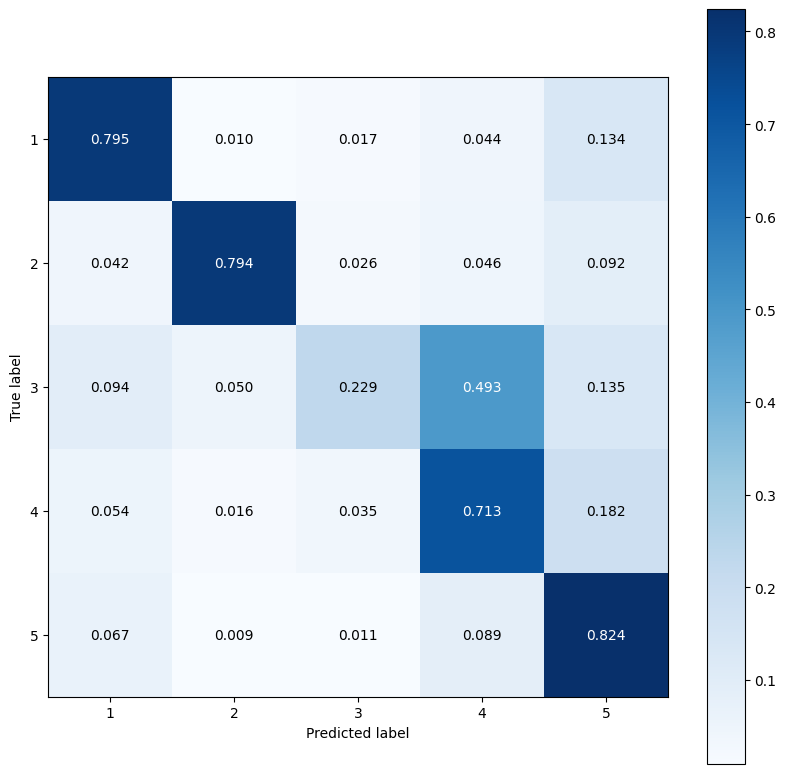

              precision    recall  f1-score   support

           1       0.74      0.79      0.77      1091
           2       0.75      0.79      0.77       306
           3       0.58      0.23      0.33       542
           4       0.51      0.71      0.60       858
           5       0.86      0.82      0.84      2900

    accuracy                           0.74      5697
   macro avg       0.69      0.67      0.66      5697
weighted avg       0.75      0.74      0.74      5697



In [319]:
y_pred = model_cf_multiclass.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
plot_confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred, target_names=['1', '2', '3', '4', '5']))

The model above is sligthly overtrained (the validation loss function starts to increase around the epoch 250), as it was observed to result in more evenly dispersed values on the diagonal of the confusion matrix. Two methods were investigated to reduce the overtraining - dropout and batch normalization, but both had a 
detrimental effect on the model's performance.

### CF - multiclass, oversampled

Here we tackle the problem of class imbalancement by oversampling the minority classes in the training dataset. Thanks to that, during the training phase the model comes upon underrepresented classes more often and can understand them better.

In [320]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler(sampling_strategy='all')

In [ ]:
X_over = [[a,b] for a,b in zip(df_train.loc[:,'customer'].values, df_train.loc[:,'product'].values)]
X_over, y_over = oversample.fit_resample(X_over, y_train)

In [322]:
X_train_0 = [X_over[ii][0] for ii in range(len(X_over))]
X_train_1 = [X_over[ii][1] for ii in range(len(X_over))]
X_over = [np.array(X_train_0), np.array(X_train_1)]

In [323]:
n_factors = 50
model_cf_oversampled = ColaborativeFiltering([value_counts['customer'], value_counts['product']], n_factors, output_nodes=5, dense_nodes=10)

history = model_cf_oversampled.fit(x=X_over, y=y_over, batch_size=10**6, epochs=200,
                    verbose=0, validation_data=(X_test, y_test))

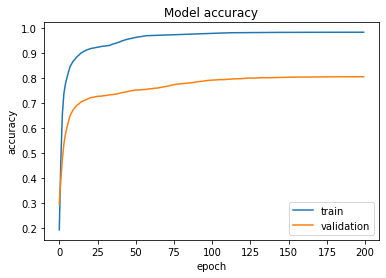

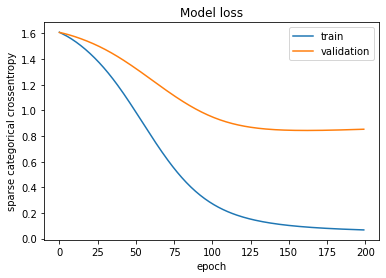

In [324]:
plot_history(history, 'accuracy', 'sparse categorical crossentropy')

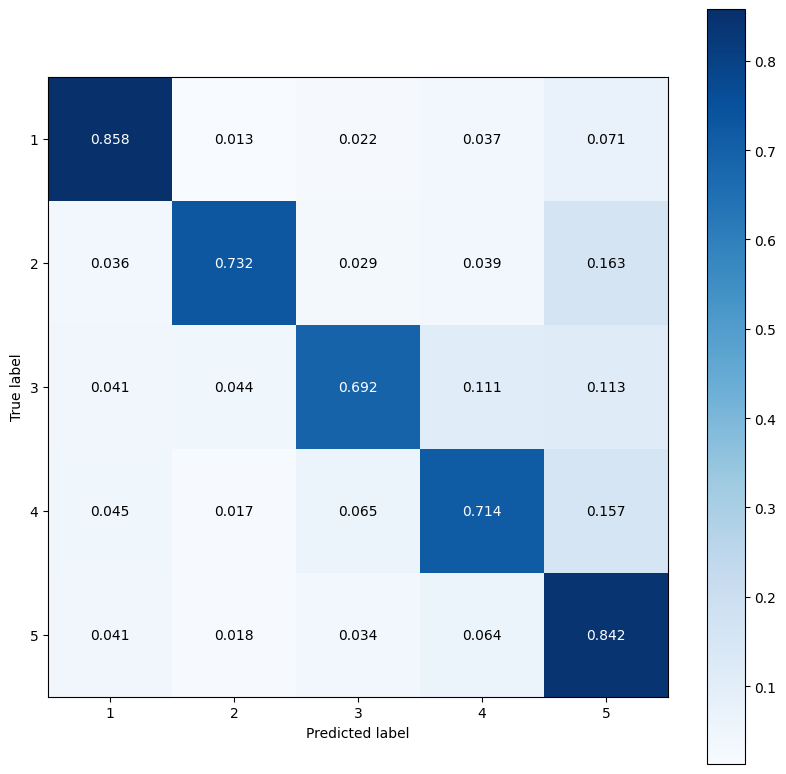

              precision    recall  f1-score   support

           1       0.83      0.86      0.84      1091
           2       0.68      0.73      0.70       306
           3       0.66      0.69      0.68       542
           4       0.67      0.71      0.69       858
           5       0.88      0.84      0.86      2900

    accuracy                           0.81      5697
   macro avg       0.75      0.77      0.76      5697
weighted avg       0.81      0.81      0.81      5697



In [325]:
y_pred = model_cf_oversampled.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
plot_confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred, target_names=['1', '2', '3', '4', '5']))


Based on the confusion matrix we see that there is a small improvement in the model's performance (the only class with a lower TP ratio than before is class number 1, the lowest review score). 

### CF multiclass, weighted

Here we tackle the problem of imbalancement in the dataset by assigning a weight to each class. Each weight is inversely proportional to the frequency of a given class. This solution is not only more elegant than oversampling, but is also less prone to overfitting (we are not copying any entries).

In [326]:
val_fracs = y_train.value_counts(1)
class_weight = {0: 1/val_fracs[0], 
                1: 1/val_fracs[1], 
                2: 1/val_fracs[2],
                3: 1/val_fracs[3],
                4: 1/val_fracs[4]}


In [327]:
n_factors=100

model_cf_weighted = ColaborativeFiltering([value_counts['customer'], value_counts['product']], n_factors, output_nodes=5, dense_nodes=50)

history = model_cf_weighted.fit(x=X_train, y=y_train, batch_size=10**6, epochs=100,
                    verbose=0, validation_data=(X_test, y_test), class_weight=class_weight)

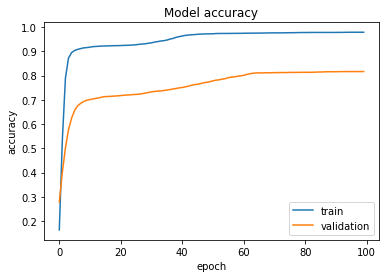

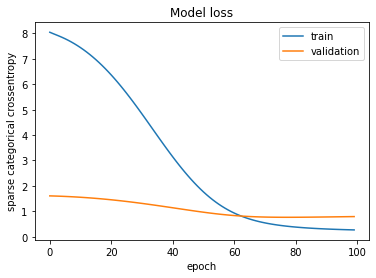

In [328]:
plot_history(history, 'accuracy', 'sparse categorical crossentropy')

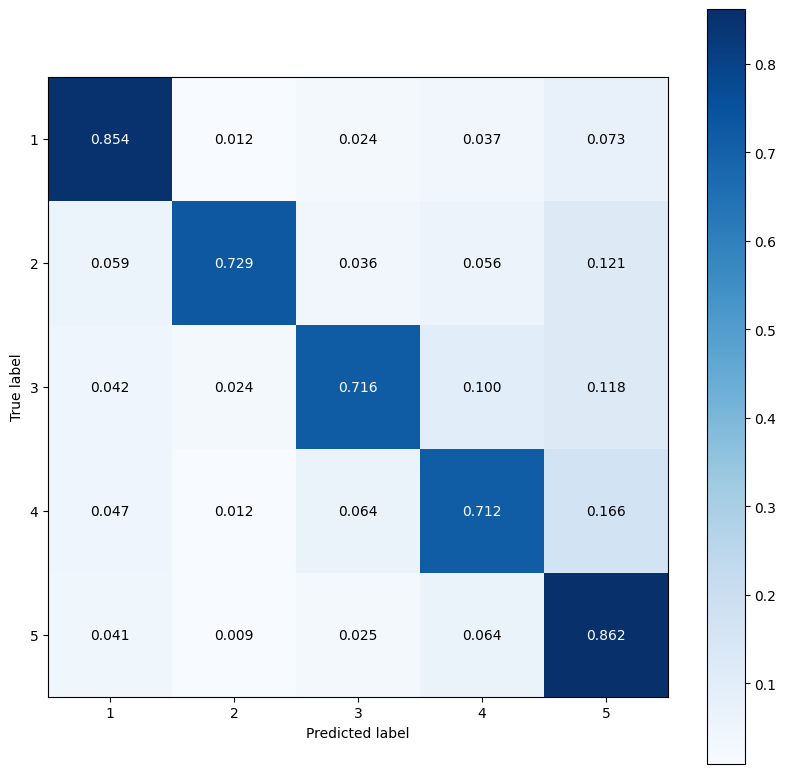

              precision    recall  f1-score   support

           1       0.82      0.85      0.84      1091
           2       0.79      0.73      0.76       306
           3       0.70      0.72      0.71       542
           4       0.67      0.71      0.69       858
           5       0.89      0.86      0.87      2900

    accuracy                           0.82      5697
   macro avg       0.77      0.77      0.77      5697
weighted avg       0.82      0.82      0.82      5697



In [330]:
y_pred = model_cf_weighted.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
plot_confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred, target_names=['1', '2', '3', '4', '5']))


Even though the weighted model performs better than the oversampled one only on some classes, using it would be probably better from a business point of view, as it predicted a perfect rating for the lowest true ratings (1 and 2) approximately twice less often. Of course, the final decision depends on a business client. On one hand, predicting too high ratings could result in wasted advertisement resources (as the system would recommend a product to a customer not interested in it), while on the other - underestimation of ratings could prevent the system from recommending a well-fitting product to a customer (who can always just ignore missed recomendations). 

### Classification by voting

As both the weighted and the oversampled model has its own strenghts and weaknesses, we decided to investigate a very simple ensemble method. In this section, we calculate a weighted average of both models' predictions, where the weights are the softmax function outputs for the given labels - the models vote for the final predictions. 

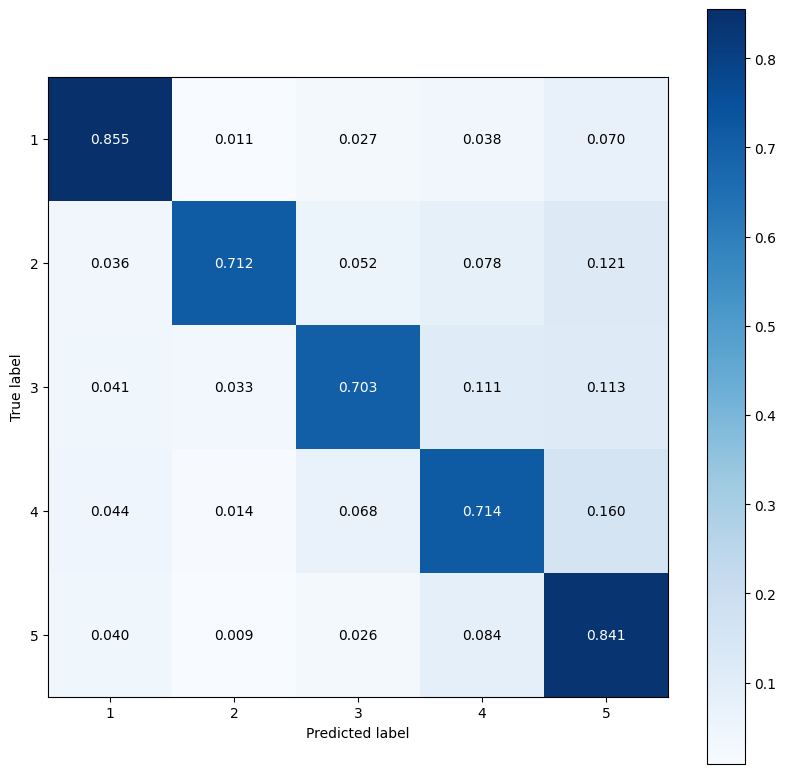

              precision    recall  f1-score   support

           1       0.83      0.86      0.84      1091
           2       0.76      0.71      0.74       306
           3       0.68      0.70      0.69       542
           4       0.62      0.71      0.67       858
           5       0.89      0.84      0.86      2900

    accuracy                           0.80      5697
   macro avg       0.76      0.77      0.76      5697
weighted avg       0.81      0.80      0.81      5697



In [332]:
y_pred_cf_over = model_cf_oversampled.predict(X_test)
label_cf_over = np.argmax(y_pred_cf_over, axis=1)
weight_cf_over = np.max(y_pred_cf_over, axis=1)

y_pred_cf_weight = model_cf_weighted.predict(X_test)
label_cf_weight = np.argmax(y_pred_cf_weight, axis=1)
weight_cf_weight = np.max(y_pred_cf_weight, axis=1)


y_pred = (label_cf_over*weight_cf_over) + (label_cf_weight*weight_cf_weight)
y_pred = y_pred / (weight_cf_over + weight_cf_weight)
y_pred = np.rint(y_pred)

plot_confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred, target_names=['1', '2', '3', '4', '5']))


The voting approach did not provide an increase in performance. Applying a more complex ensemble method (like bagging) could improve the classification scores, but to perform it efficiently a bigger dataset would be needed, as each ensemble model should be trained on another, informative subset.

## Comparison with the matrix approach

In the notebook Recommender_system_1.ipynb we developed traditional, matrix factorization based recommender models. Here we use the best of them (Biased NMF) to compute a confusion matrix on a test dataset and compare its performance with the DL approaches. 

In [333]:
model_nmfb = pickle.load(open('model_nmfb.sav', 'rb'))

In [334]:
def recommendations(users,products,model):
    recommendations = []
    for user, product in zip(users, products):
        r = model.predict(user, product, verbose=False).est
        recommendations.append(r)
    
    return recommendations

In [335]:
y_pred_matrix = np.rint(recommendations(X_test[0],X_test[1],model_nmfb))-1

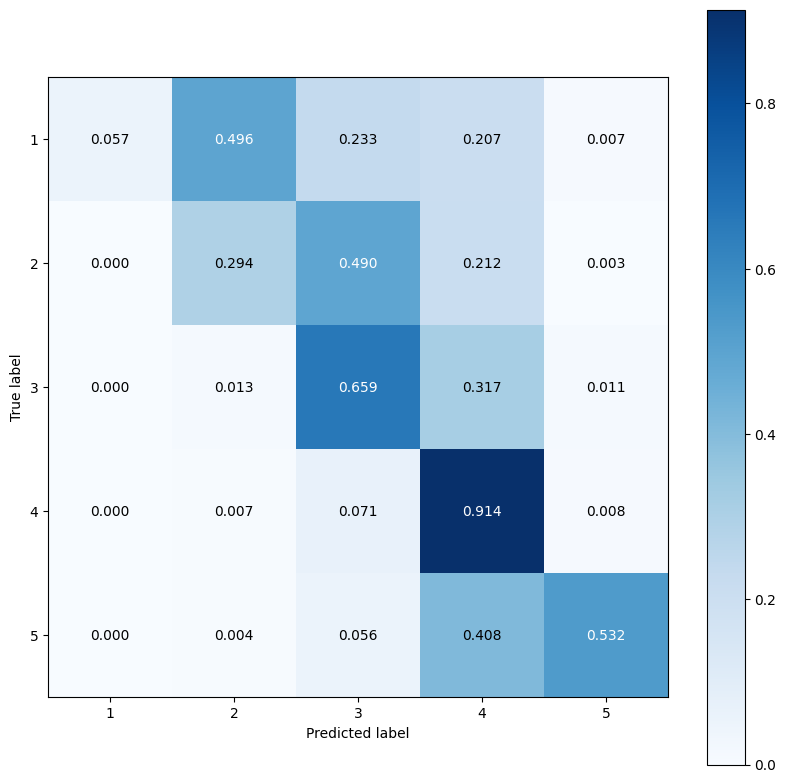

              precision    recall  f1-score   support

           1       1.00      0.06      0.11      1091
           2       0.14      0.29      0.19       306
           3       0.36      0.66      0.47       542
           4       0.32      0.91      0.48       858
           5       0.99      0.53      0.69      2900

    accuracy                           0.50      5697
   macro avg       0.56      0.49      0.39      5697
weighted avg       0.78      0.50      0.50      5697



In [336]:
plot_confusion_matrix(y_test, y_pred_matrix)
print(classification_report(y_test, y_pred_matrix, target_names=['1', '2', '3', '4', '5']))


The performance of the traiditional model is in most cases significantly lower than the one of the DL models. This may be however caused by a different choice of the train and test sets. To check it, we retrain the Biased NMF model using the original hyperparameters, but using the same train dataset as for the DL models.

In [337]:
reader = Reader(rating_scale=(1,5))
data_surprise = Dataset.load_from_df(df_train.loc[:, ['customer', 'product', 'review_score']], reader)

In [338]:
model_nmfb.fit(data_surprise.build_full_trainset())

In [339]:
# here we subtract 1 from all predictions to move them from the range [1,5] 
# to [0,4], so that they agree with the preprocessed true ratings
y_pred_matrix = np.rint(recommendations(X_test[0],X_test[1],model_nmfb))-1

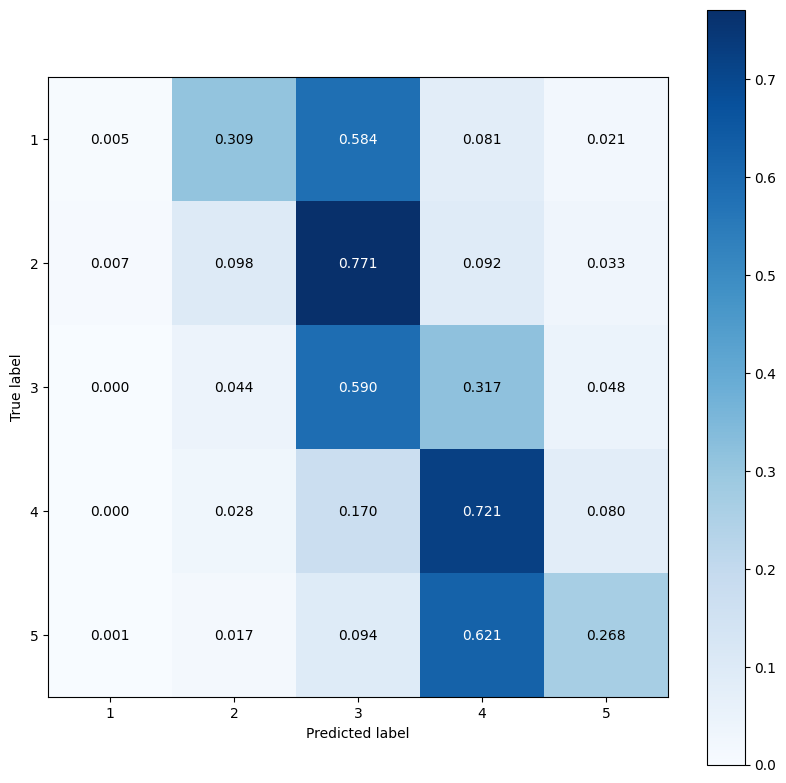

              precision    recall  f1-score   support

           1       0.55      0.01      0.01      1091
           2       0.06      0.10      0.08       306
           3       0.20      0.59      0.30       542
           4       0.23      0.72      0.35       858
           5       0.86      0.27      0.41      2900

    accuracy                           0.31      5697
   macro avg       0.38      0.34      0.23      5697
weighted avg       0.60      0.31      0.29      5697



In [341]:
plot_confusion_matrix(y_test, y_pred_matrix)
print(classification_report(y_test, y_pred_matrix, target_names=['1', '2', '3', '4', '5']))


For most classes the values on the diagonal are still lower than the ones obtained with the DL models. Moreover, the Biased NMF model usually misclassifies samples belonging to the extreme classes (1 and 5). Based on this brief comparison, it appears that the DL-based approach is more accurate than the traditional one.

## Binary approach

### Label selection

In [342]:
y_train = df_train.rating
y_test = df_test.rating

### CF - binary

In [343]:
n_factors = 15
model_cf_binary = ColaborativeFiltering([value_counts['customer'], value_counts['product']], n_factors, dense_nodes=10)

history = model_cf_binary.fit(x=X_train, y=y_train, batch_size=10**6, epochs=400,
                    verbose=0, validation_data=(X_test, y_test))

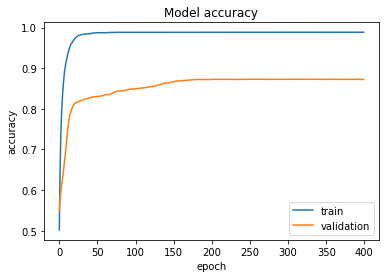

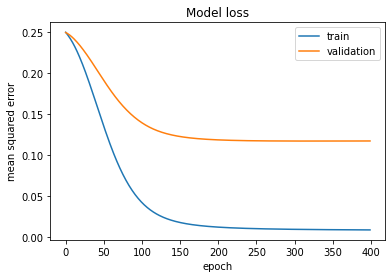

In [344]:
plot_history(history, 'accuracy', 'mean squared error')

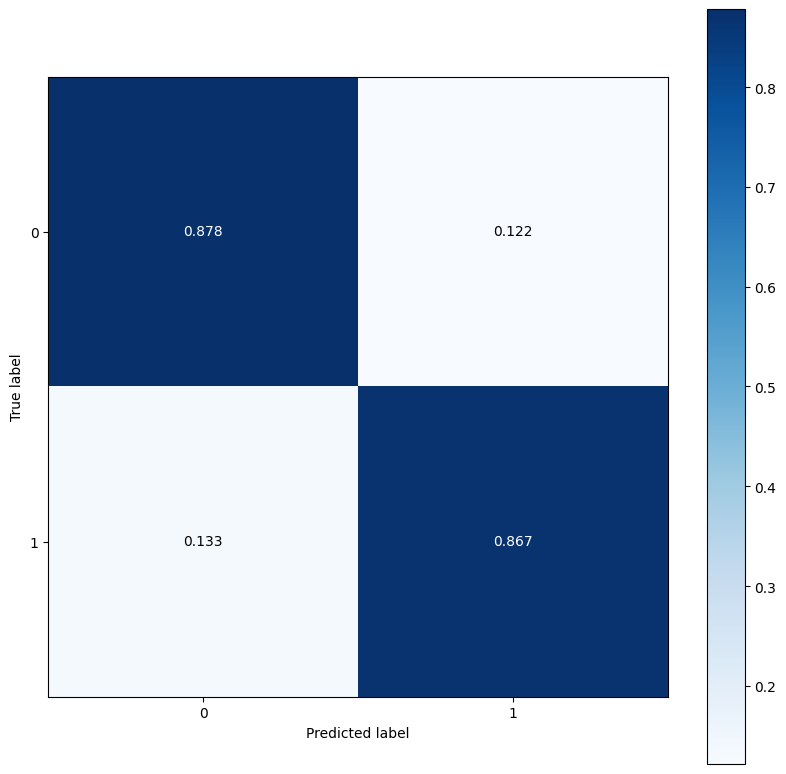

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      2797
           1       0.88      0.87      0.87      2900

    accuracy                           0.87      5697
   macro avg       0.87      0.87      0.87      5697
weighted avg       0.87      0.87      0.87      5697



In [345]:
y_pred = model_cf_binary.predict(X_test)
y_pred = np.rint(y_pred)
plot_confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred, target_names=['0', '1']))


## NeuMF 

In [346]:
n_factors = 100
model_neumf = NeuMF(value_counts['customer'], value_counts['product'], n_factors, [250,50,10])

history = model_neumf.fit(x=X_train, y=y_train, batch_size=10**6, epochs=60,
                    verbose=0, validation_data=(X_test, y_test))

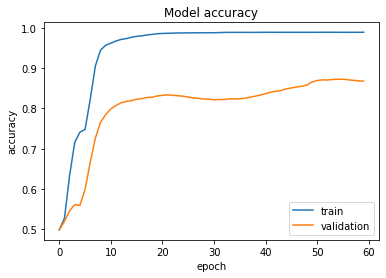

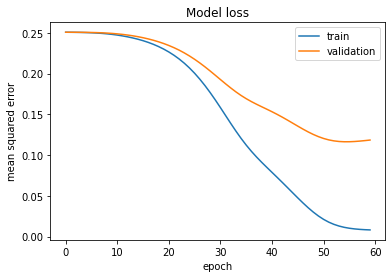

In [347]:
plot_history(history, 'accuracy', 'mean squared error')

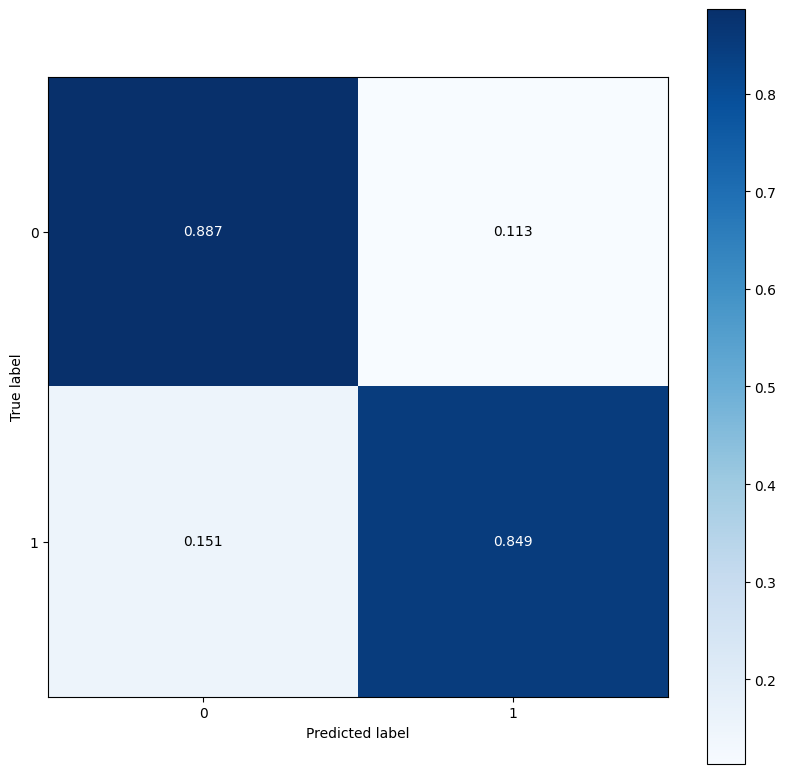

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      2797
           1       0.89      0.85      0.87      2900

    accuracy                           0.87      5697
   macro avg       0.87      0.87      0.87      5697
weighted avg       0.87      0.87      0.87      5697



In [348]:
y_pred = model_neumf.predict(X_test)
y_pred = np.rint(y_pred)
plot_confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred, target_names=['0','1']))


### Classification by voting

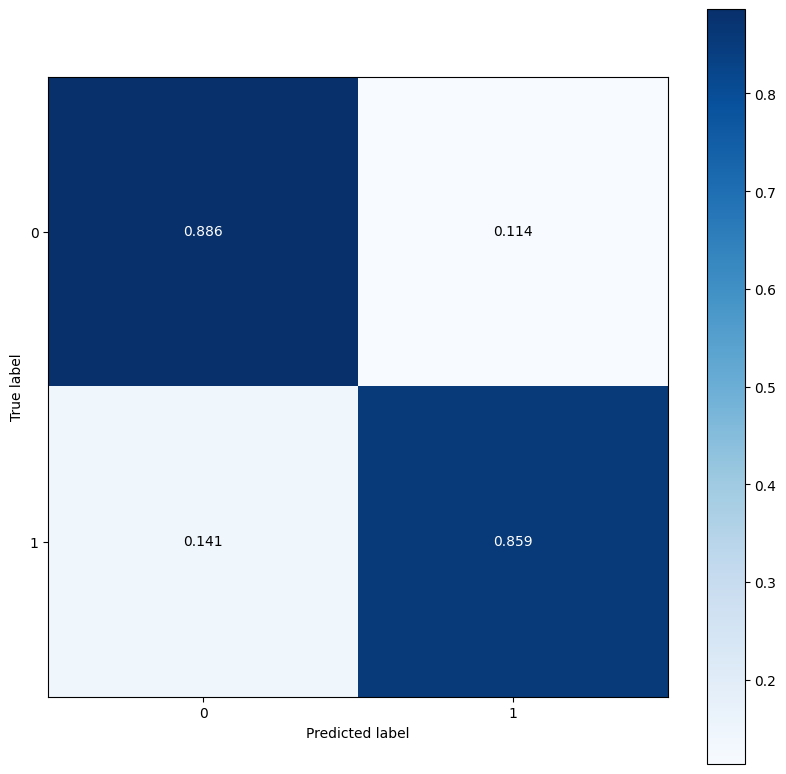

              precision    recall  f1-score   support

           0       0.86      0.89      0.87      2797
           1       0.89      0.86      0.87      2900

    accuracy                           0.87      5697
   macro avg       0.87      0.87      0.87      5697
weighted avg       0.87      0.87      0.87      5697



In [349]:
y_pred_cf_bin = model_cf_binary.predict(X_test)
y_pred_neumf = model_neumf.predict(X_test)

y_pred = np.mean([y_pred_cf_bin, y_pred_neumf], axis=0)
y_pred = np.rint(y_pred)
plot_confusion_matrix(y_test, y_pred)
print(classification_report(y_test, y_pred, target_names=['0','1']))


Overall, both models (NCF and NeuMF) showed similar and high performance. The voting approach did not improve the classification scores.

# State-category approach

## Data preparation

The dataset for the state - category variant had to be preprocessed differently than for the customer - product case. First we calculate a mean review score for each state - category pair and perform a train-validation-test split (70/15/15) in such a way that each state appears at least once in each set.

In [350]:
df_recommender = pd.read_csv('recommender.csv', usecols='order_delivered_customer_date,product_category_name_english,customer_state,review_score'.split(','), 
                             parse_dates=['order_delivered_customer_date'])

In [351]:
df_recommender.head()

,review_score,customer_state,product_category_name_english,order_delivered_customer_date
0,4,SP,housewares,2017-10-10 21:25:13
1,4,SP,housewares,2017-08-18 14:44:43
2,5,SP,housewares,2017-08-07 18:30:01
3,3,SC,housewares,2017-11-07 18:04:59
4,1,SP,housewares,2017-08-28 20:12:20


In [352]:
df_recommender = df_recommender.rename(columns = {'customer_state': 'state', 'product_category_name_english': 'category', 'order_delivered_customer_date': 'timestamp'})

In [353]:
def binarize_ratings(rating):
    if rating == 5:
        return 1
    else:
        return 0

In [354]:
df_recommender['rating'] = df_recommender.review_score.apply(binarize_ratings)

In [355]:
df_recommender_mean = df_recommender.groupby(['state', 'category']).review_score.mean().reset_index()

In [356]:
df_recommender_mean.groupby('state').category.count()

state
AC    27
AL    42
AM    37
AP    21
BA    62
CE    52
DF    60
ES    58
GO    62
MA    47
MG    68
MS    54
MT    54
PA    50
PB    46
PE    56
PI    48
PR    64
RJ    68
RN    45
RO    41
RR    16
RS    65
SC    64
SE    41
SP    70
TO    38
Name: category, dtype: int64

In [357]:
encoder = OrdinalEncoder()
encoder.fit(df_recommender_mean.loc[:,['state', 'category']])

OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>)

In [358]:
def train_test_time_split(df, frac, binary=False):
    g = df
    if binary:
        g = g.groupby(['state', 'rating'])
    else:
        g = g.groupby(['state'])

    flags = (g.cumcount() + 1) <= g['state'].transform('size') * frac
    df_test = df.loc[flags]
    df_train = df.loc[~flags]
    return df_train, df_test
        

In [359]:
df_train, df_test = train_test_time_split(df_recommender_mean, 0.3)
df_val, df_test = train_test_time_split(df_test, 0.5)

In [360]:
cols = ['state', 'category']
X_train_0 = encoder.transform(df_train.loc[:, cols])
X_val_0 = encoder.transform(df_val.loc[:, cols])
X_test_0 = encoder.transform(df_test.loc[:, cols])

In [361]:
def encoded_to_list_of_lists(X):
    result = []
    for feature in range(X.shape[1]):
        result.append(np.array([X[nn, feature] for nn in range(X.shape[0])]))
    return result

In [362]:
X_train = encoded_to_list_of_lists(X_train_0)
X_val = encoded_to_list_of_lists(X_val_0)
X_test = encoded_to_list_of_lists(X_test_0)

In [363]:
y_train = df_train.loc[:, 'review_score'] - 1
y_val = df_val.loc[:, 'review_score'] - 1
y_test = df_test.loc[:, 'review_score'] - 1

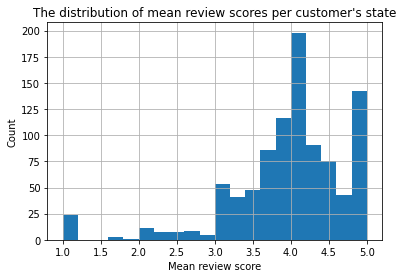

In [364]:
df_train.loc[:, 'review_score'].hist(bins=20)
plt.ylabel('Count')
plt.xlabel('Mean review score')
plt.title("The distribution of mean review scores per customer's state");

In [365]:
len(df_train)

959

## Hyperparameter optimization and model training

To select an optimal set of the model's hyperparameters we used the functionality provided by the keras-tuner module, precisely a bayesian optimization method.


In [366]:
def model_builder(hp):

    hp_n_factors = hp.Choice('n_factors', values=[5, 15, 55, 100, 155])
    hp_dense_nodes = hp.Choice('dense_nodes', values=[1, 10, 50, 100, 150, 300, 500])
    
    model = CFRegressor([df_recommender.state.nunique(), df_recommender.category.nunique()], hp_n_factors, 1, hp_dense_nodes)
    return model

In [369]:
tuner = kt.BayesianOptimization(model_builder,
                     objective='val_loss',
                     max_trials=40,
                     directory=os.path.normpath('hypertune_B4'))


In [370]:
# attention: this function does not work on Windows due to the path length limit
tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val))


Trial 40 Complete [00h 00m 10s]
val_loss: 0.8208200335502625

Best val_loss So Far: 0.7584699988365173
Total elapsed time: 00h 07m 17s
INFO:tensorflow:Oracle triggered exit


In [371]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


In [372]:
for hparameter in 'n_factors,dense_nodes'.split(','):
  print(f'{hparameter}: {best_hps.get(hparameter)}')

n_factors: 5
dense_nodes: 500


In [373]:
n_factors=best_hps.get('n_factors')

model_cf_citystate = CFRegressor([df_recommender.state.nunique(), df_recommender.category.nunique()], 
                                 n_factors, output_nodes = 1, dense_nodes=best_hps.get('dense_nodes'))

history = model_cf_citystate.fit(x=X_train, y=y_train, batch_size=10**6, epochs=300,
                    verbose=0, validation_data=(X_val, y_val))

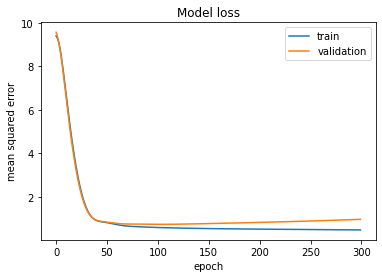

In [374]:
plot_history(history, None, 'mean squared error')


In [375]:
model_cf_citystate.evaluate(X_test, y_test)


7/7 [==============================] - 0s 3ms/step - loss: 0.8542


0.8542024493217468

In [376]:
from sklearn.metrics import r2_score
y_pred = model_cf_citystate.predict(X_test)
print(f'R2 score = {r2_score(y_test, y_pred)}')

R2 score = -0.13714193721133316


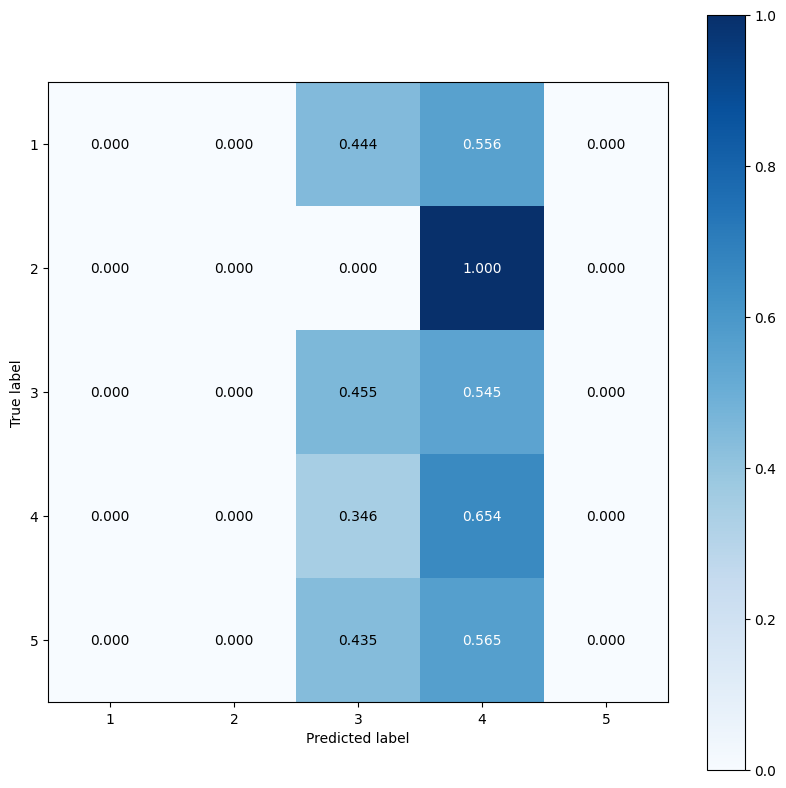

In [378]:
plot_confusion_matrix(np.rint(y_test), np.rint(y_pred))


Among the models presented in this notebook, the regressor for the state - category approach performs the worst. Both the negative R$^2$ value and the confusion matrics indicate that the model does not fit the data. One of the reasons may be that the data is - again - imbalanced, with most of the mean ratings being around 3-4. Moreover, the dataset obtained in this part is very small - the training set consists of less than 1000 entries, which can be too little of a deep learning model to work properly. In this case, a simpler method could give better results.


# Conclusion

## Customer-product approach

The models obtained for this approach performed well on the given test set. For the multiclass variant they overperformed the Biased NMF model developed in Recommender_system_1.ipynb. The choice of a particular model depends on the business client's needs and preferences, however we recommend the weighted NCF model for explicit feedback recommendation, as it does not require resampling of the dataset, and the NeuMF model for implicit feedback recommendation, due to its ability to combine the strengths of matrix factorization and NCF.

Regarding the customer-product recommendation, it is also important to mention that the problem of cold start customers or customers with too little ratings may be tackled by developing a cross domain recommender system, in which we use the customer's preferences learned based on one domain (product category) to recommend them products from another. For this task, a NeuCDCF model, similar to NeuMF, could be applied. However, due to the model's complexity a bigger dataset should be provided for this kind of research.

References:
Vijaikumar M, Shirish Shevade, M N Murty: “Neural Cross-Domain Collaborative Filtering with Shared Entities”, 2019; <a href='http://arxiv.org/abs/1907.08440'>arXiv:1907.08440</a>.

## State-category approach

The model developed for this variant was not able to fit the data correctly. It is possible that the reason for this was the problem's formulation that shrinked the dataset too much for a deep learning model. Although, even if the optimal model's performance cannot be achieved, the sole information about the mean category rating in each state can be used as an another factor helping to solve the cold start problem. 